In [16]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np

In [4]:
from data.dataset import VideoDataSet
from sklearn.preprocessing import LabelEncoder
import random
import numpy as np
train_dataset = VideoDataSet('train')
test_dataset = VideoDataSet('test')
le = LabelEncoder()
label = train_dataset.get_label()
le.fit(label)



LabelEncoder()

In [5]:

def collate_fn(batch):
    frames = [b[0] for b in batch]
    masks = [torch.ones(b[0].shape[0]) for b in batch]
    frames = torch.nn.utils.rnn.pad_sequence(frames)
    masks = torch.nn.utils.rnn.pad_sequence(masks)
    frames = torch.transpose(frames, 0 , 1)
    masks = torch.transpose(masks, 0 , 1)
    item = le.transform([b[1] for b in batch])
    labels = torch.tensor(item)
    return (frames, masks), labels

batch_size = 32
class_num = len(label)
# train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32, collate_fn = collate_fn)
# test_data_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32, collate_fn = collate_fn)
train_dataset = torch.load('train_data.pt')
train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, collate_fn = collate_fn)
test_dataset = torch.load('test_data.pt')
test_data_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, collate_fn = collate_fn)

In [11]:
from tqdm import tqdm
def train(data_loader, model, loss_fn, optimizer, masking):
    model.to('cuda')
    model.train()
    # pbar = tqdm(range(len(data_loader)))
    correct = 0
    for batch, (X, y) in enumerate(data_loader):
        # pbar.update()
        frames, mask = X
        frames = frames.to('cuda')
        y = y.type(torch.int64)

        pred = model(frames)
        pred = pred.to('cpu')
        if masking:
            mask = torch.count_nonzero(mask,axis=-1) - 1
            mask = torch.reshape(mask, (mask.shape[0],1,1))
            mask = torch.tile(mask, (1,1,class_num))
            pred = torch.gather(pred, 1, mask)
            pred = torch.squeeze(pred)
        else:
            pred = pred[:,-1,:]
            
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    #     pbar.set_description(f'loss:{loss.item():<.3f} acc:{correct / (data_loader.batch_size*(batch+1)) * 100 :.3f}%')
    # del pbar

def test(data_loader, model, loss_fn, masking):
    pbar = tqdm(range(len(data_loader)))
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(data_loader):
            pbar.update()
            frames, mask = X
            frames = frames.to('cuda')
            y = y.type(torch.int64)

            pred = model(frames)
            pred = pred.to('cpu')
            if masking:
                mask = torch.count_nonzero(mask,axis=-1) - 1
                mask = torch.reshape(mask, (mask.shape[0],1,1))
                mask = torch.tile(mask, (1,1,class_num))
                pred = torch.gather(pred, 1, mask)
                pred = torch.squeeze(pred)
            else:
                pred = pred[:,-1,:]

            loss = loss_fn(pred, y)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            pbar.set_description(f'loss:{loss.item():<.3f} acc:{correct / (data_loader.batch_size*(batch+1)) * 100 :.3f}%')
    del pbar

In [53]:

import Model

loss_fn = nn.CrossEntropyLoss()

print("train with masking")

for _ in range(1):
    model = Model.CNNRNN(class_num)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for i in range(20):
        train(train_data_loader, model, loss_fn, optimizer, True)
    test(test_data_loader, model, loss_fn, True)

torch.save(model,'model_trained.pth')
print("train without masking")
for _ in range(1):
    model = Model.CNNRNN(class_num)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for i in range(20):
        train(train_data_loader, model, loss_fn, optimizer, False)
    test(test_data_loader, model, loss_fn, False) 


train with masking


loss:0.936 acc:95.536%: 100%|██████████| 7/7 [00:00<00:00, 150.49it/s]


train without masking


loss:0.966 acc:95.982%: 100%|██████████| 7/7 [00:00<00:00, 164.62it/s]


c:\Users\evilr\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\io\video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


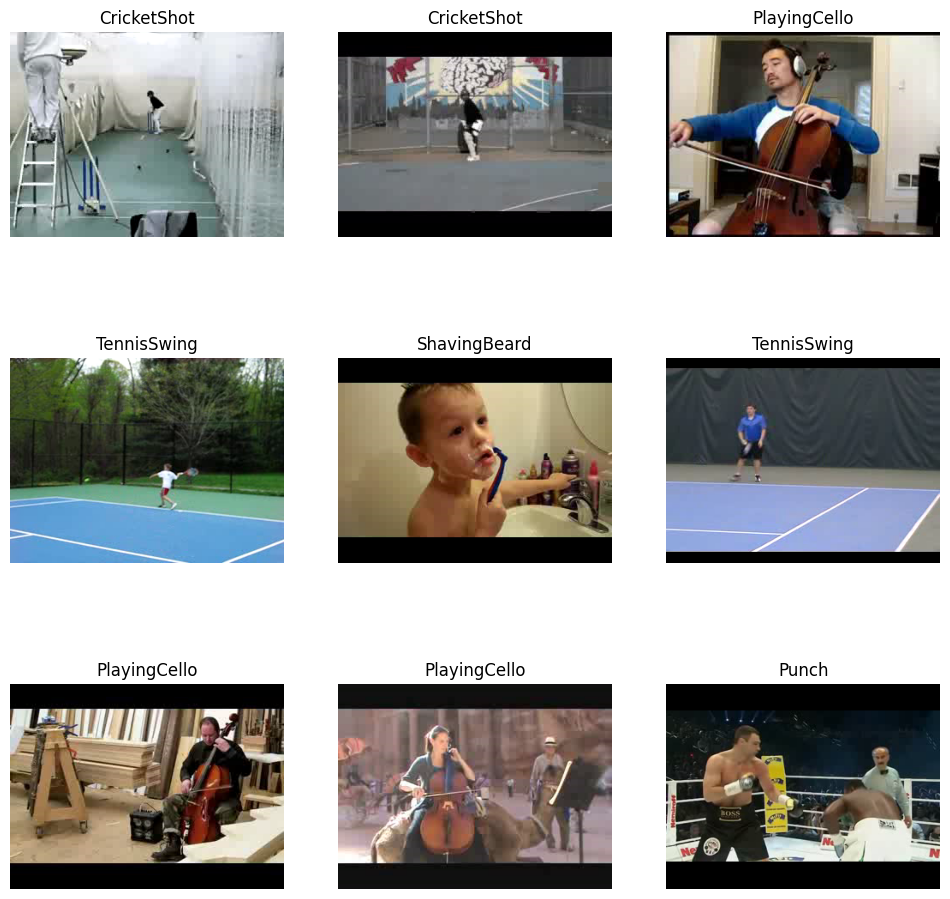

In [88]:
#result visualize
import matplotlib.pyplot as plt
model = torch.load('model_trained.pth')

correct = 0
# for t in test_dataset:
#     X = t[0]
#     label = t[1]
#     X = torch.unsqueeze(X, 0).to('cuda')
#     output = model(X)
    
#     output = torch.argmax(output[0,-1,:])
#     label = le.transform([label])
#     correct += (output == label[0]).item()

# print(correct / len(test_dataset) * 100)
def draw_sample(model, dataset, idx, ax):
    video_path = dataset.data_csv.iloc[idx]['video_name']
    X = dataset[idx][0]
    label = dataset[idx][1]
    X = torch.unsqueeze(X, 0).to('cuda')
    frames, _, _ = torchvision.io.read_video(video_path)
    ax.imshow(frames[0])
    
    frames = torch.permute(frames, [0,3,1,2])
    frames = frames[::10]
    output = model(X)
    output = torch.argmax(output[0,-1,:])
    output_label = le.inverse_transform([output.item()])
    ax.set_title(output_label[0])
    ax.axis('off')

fig, ax = plt.subplots(3,3,figsize=(12,12))

for i in range(9):
    draw_sample(model, train_dataset, i, ax[i//3][i%3])